In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math
import plotly.express as px
import pandas as pd
import numpy as np

## 1. Load the Karate Graph from NetworkX

In [2]:
def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    print("Available nodes:", list(graph.nodes))
    print("Available edges:", list(graph.edges))
    if type(graph) == nx.classes.digraph.DiGraph:
        print("Connected components:", 
              list(nx.weakly_connected_components(directed_graph)))
    else:
        print("Connected components:", list(nx.connected_components(graph)))
    print("Node degree:", dict(graph.degree()))

In [3]:
# built-in graph from networkx
karate_graph = nx.karate_club_graph()
get_graph_info(karate_graph)

Number of nodes: 34
Number of edges: 78
Available nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Available edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]
Connected components: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,

In [4]:
# club color reference
nation_color_dict = {
    'Mr. Hi': '#aff8df',
    'Officer': '#ffcbc1'
}

# function to assign color for node visualization
def create_node_colors_from_graph(graph, club_color_dict):
    node_colors = []
    for node, club in list(graph.nodes(data="club")):
        if club in club_color_dict:
            node_colors.append(club_color_dict[club])
    return node_colors

# get node colors for plotting
node_colors = create_node_colors_from_graph(karate_graph, nation_color_dict)

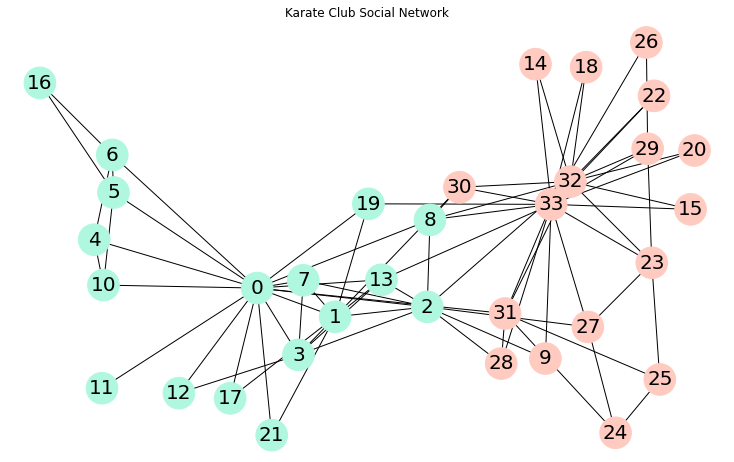

In [5]:
# create visualization
pos = nx.spring_layout(karate_graph, 
                       k=0.3, iterations=50,
                       seed=2)

plt.figure(1,figsize=(10,6)) 
nx.draw(karate_graph,
        pos = pos,
        node_color=node_colors,
        node_size=1000,
        with_labels=True,
        font_size = 20,
        font_color='black')
plt.title("Karate Club Social Network")
plt.show()

### Mint color nodes are from the "Mr. Hi" Karate club and the Salmon color nodes are from the "Officer" Karate club. 

## Community Detection

### 2.0 Modularity:

* Modularity is widely used as a measure for how good a clustering is.  
* Modularity compares the number of edges inside a cluster with the expected number of edges that one would find in the cluster.
* A good modularity score falls within 0.3-0.7. 
* When modularity is close to 1, it indicates strong community structure. 
* When modularity is 0, it indicates the community division is worse than random.

Modularity suffers a resolution limit and, therefore, it is unable to detect small communities.


1. Definition: 
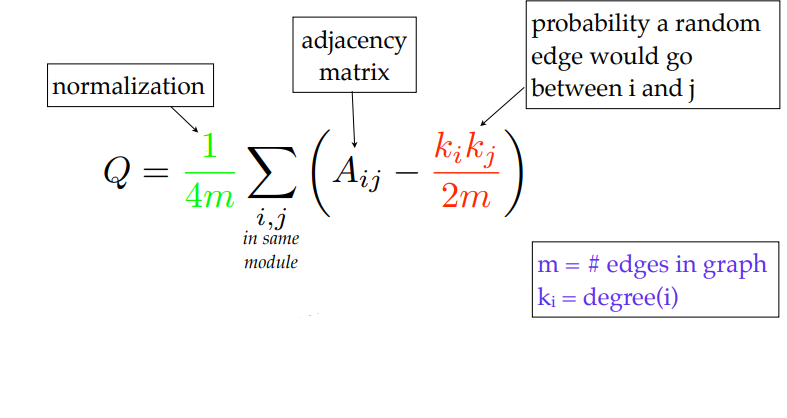

In [6]:
# function to return a node's neighbor nodes as a list
def get_neighbors(graph, node):
    return [n for n in graph.neighbors(node)]

In [7]:
# function to return the subgraph containing 2 nodes' common neighbors
def get_common_neighbor_subgraph(graph, source, target):
    nodes = [source, target] + list(nx.common_neighbors(karate_graph, source, target))
    return graph.subgraph(nodes)

### 2.1 Girvan-Newman:

1. Definition:
    * Detects communities by progressively removing edges from the original graph. 
    * The algorithm removes the "most valuable" edge, traditionally the edge with the highest betweenness centrality, at each step. 
    * As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.
    
2. How to:  
    Step 1: For every edge in a graph, calculate the edge betweenness centrality.  
    Step 2: Remove the edge with the highest betweenness centrality.  
    Step 3: Calculate the betweenness centrality again for every remaining edge.  
    Step 4: Repeat steps 2-3 until there are no more edges left.  

In [31]:
from networkx.algorithms.community.centrality import girvan_newman
import networkx.algorithms.community as nx_comm

In [30]:
# find communities
girvan_newman_communities = list(girvan_newman(karate_graph))

### let's study how does modularity changes as important edges been removed

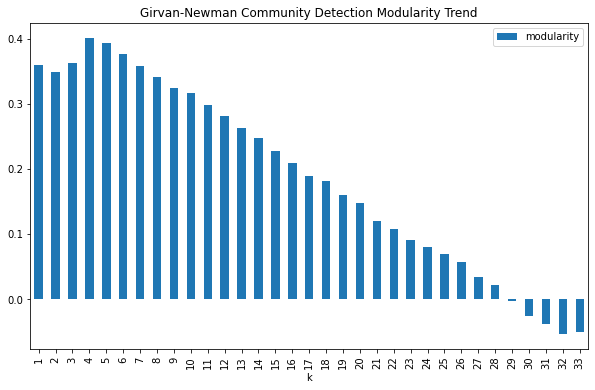

In [40]:
modularity_df = pd.DataFrame([[k+1, round(nx_comm.modularity(karate_graph, community_list[k]), 6)]
                for k in range(len(community_list))],
                            columns=["k", "modularity"])
modularity_df.plot.bar(x="k", figsize=(10,6), title="Girvan-Newman Community Detection Modularity Trend");

### From the above choice of K, we can observe the modularity decreases as k increases. It implies weaker community structure as more edges being removed and more cluster being formed. 

In [45]:
# function create node color list for less than 7 communities
# when there are more than 6 colors, visualization can be confusing for human
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784",
              "#FFF176", "#BDBDBD"][:number_of_colors]
    node_colors = []
    
    # iterate each node in the graph and find which community it belongs to
    # if the current node is found at a specific community, add color to the 
    # node_colors list
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

In [54]:
def visualize_communities(graph, communities):
    # create visualization
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx_comm.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, 
                           k=0.3, iterations=50,
                           seed=2)

    plt.figure(1,figsize=(10,6)) 
    nx.draw(graph,
            pos = pos,
            node_size=1000,
            node_color=node_colors,
            with_labels=True,
            font_size = 20,
            font_color='black')
    plt.title(title)
    plt.show() 

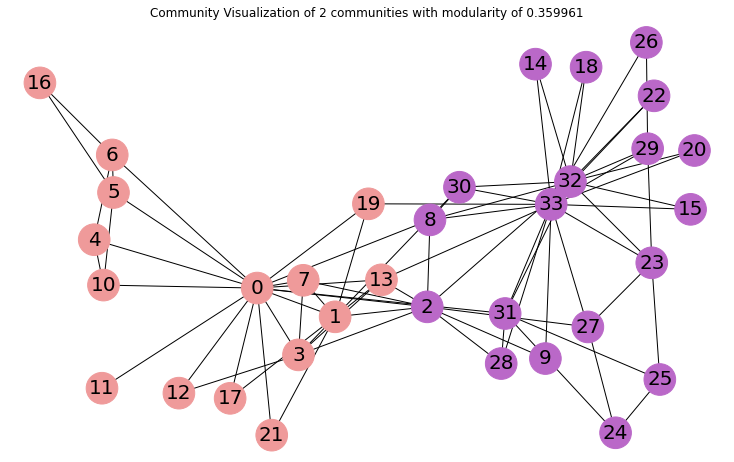

In [55]:
visualize_communities(karate_graph, girvan_newman_communities[0])

### K = 4 has the highest modularity score. Let's take a look at how Girvan-Newman algorithm partitions the network with 4 edges removed. 

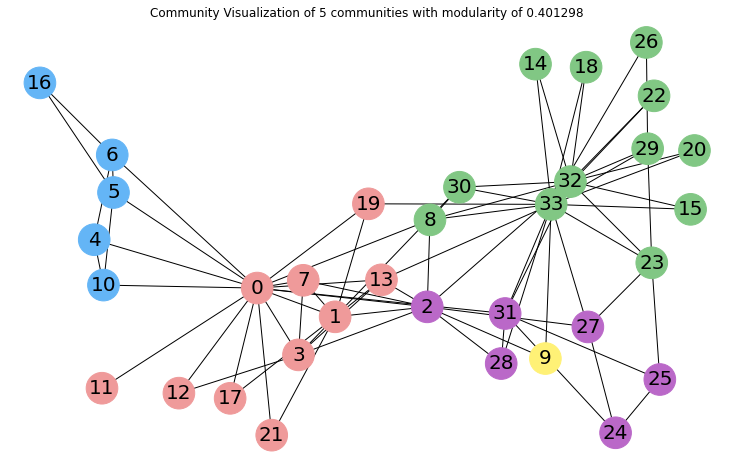

In [60]:
visualize_communities(karate_graph, girvan_newman_communities[3])

### After 4th iteration, the above visualization is the final partitions of graph based on removing the edge with highest betweenness centrality at each iteration. 

### 2.1 Girvan-Newman:

1. Definition:
    * Detects communities by progressively removing edges from the original graph. 
    * The algorithm removes the "most valuable" edge, traditionally the edge with the highest betweenness centrality, at each step. 
    * As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.
    
2. How to:  
    Step 1: For every edge in a graph, calculate the edge betweenness centrality.  
    Step 2: Remove the edge with the highest betweenness centrality.  
    Step 3: Calculate the betweenness centrality again for every remaining edge.  
    Step 4: Repeat steps 2-3 until there are no more edges left.  